# Introductory Matters:

Here in this notebook we're going to do a little bit of work with the JSTOR Constellate [data builder](https://constellate.org/builder). I started by searching "free speech" and "First Amendment" as keywords, grabbing all the "full text" document types within the "Law" category. Constellate also has a nice feature that gives assigns a "Dataset ID" to each of the datasets one builds. The one for this project is "b7adbb84-6bec-549e-83bb-11aeb045e5f9". 

## Getting our Libraries Imported

In [1]:
import gzip
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import circlify

## Loading the Data:

I simply downloaded the built dataset to my local machine (other options for loading the dataset are available [here](https://constellate.org/tutorials/exploring-metadata)—the downloaded  file comes as a `.gz` file, so we need to open that up with the handy [`gzip` library](https://docs.python.org/3/library/gzip.html). We want to do a little bit of work with [`pandas`](https://pandas.pydata.org/docs/) here (we could work, of course, just with the standard `json` library, but we're going to want to do some manipulation on the data and pandas is perfecty suited for that). So let's get the file opened and into a DataFrame:

In [2]:
df = pd.read_json(gzip.open('law_full.jsonl.gz'), lines=True)

Initial inspection of the dataframe:

In [3]:
df.head()

,creator,datePublished,docSubType,docType,fullText,id,identifier,isPartOf,issueNumber,language,...,wordCount,unigramCount,bigramCount,trigramCount,abstract,collection,editor,hasPartTitle,keyphrase,subTitle
0,[Thomas Reed Powell],1922-01-01,research-article,article,"[MICHIGAN LAW REVIEW VOL. XX JANUARY, 1922 No....",http://www.jstor.org/stable/1277162,"[{'name': 'issn', 'value': '00262234'}, {'name...",Michigan Law Review,3.0,[eng],...,11348,"{'denied.': 1, 'opposing': 3, 'take': 5, 'retr...","{'basis of': 1, 'in 69': 2, 'once the': 1, 'in...","{'manufacturing or domestic': 1, 'Prices of Co...",NaN,NaN,NaN,NaN,NaN,NaN
1,"[Elizabeth Goitein, Faiza Patel]",2020-10-22,NaN,report,[TRANSITION 2020–2021 A Presidential Agenda fo...,http://www.jstor.org/stable/resrep28426,"[{'name': 'local_uuid', 'value': '3dbcbae0-0d2...",NaN,NaN,[eng],...,13697,"{'MacArthur': 1, 'secrecy,': 1, 'com/infectiou...","{'that individuals': 1, 'for FY': 1, 'end, the...","{'Amendment, and the': 1, '10 values of': 1, '...",American democracy urgently needs renewal. In ...,[Research Reports],NaN,NaN,NaN,NaN
2,[H. R. M.],1922-09-01,research-article,article,[512 10 CALIFORNIA LAW REVIEW CRIMINAL LAW: CR...,http://www.jstor.org/stable/3474218,"[{'name': 'issn', 'value': '00081221'}, {'name...",California Law Review,6.0,[eng],...,4012,"{'acts.': 2, 'stolen.': 1, '45': 1, 'proponent...","{'in Abrams': 1, 'tendencies. According': 1, '...","{'check is necessary': 1, 'opposition to organ...",NaN,NaN,NaN,NaN,NaN,NaN
3,"[Alex Molnar, Faith Boninger, Gary Wilkinson, ...",2010-12-02,NaN,report,[EFFECTIVELY EMBEDDED SCHOOLS AND THE MACHINER...,http://www.jstor.org/stable/resrep42044,"[{'name': 'local_uuid', 'value': '4df59bdd-9e8...",NaN,NaN,[eng],...,16250,"{'Modern': 1, 'contests,': 2, 'fact,': 4, 'Che...","{'and Faith': 2, 'Michelle Obama': 1, '(Contin...","{'(2009). Age of': 1, 'In modern society,': 1,...",In the context of the last two years’ recessio...,[Research Reports],[Kevin Welner],NaN,NaN,NaN
4,[Thomas Raeburn White],1904-01-01,research-article,article,[THE AMERICAN LAW REGISTER FOUNDED 1852 UNIVER...,http://www.jstor.org/stable/3306378,"[{'name': 'issn', 'value': '15583562'}, {'name...",The American Law Register (1898-1907),1.0,[eng],...,7567,"{'contrary,': 1, 'scandalous': 1, 'thought': 4...","{'supposition is': 1, 'publications, however':...","{'believing in the': 1, 'the institution of': ...",NaN,NaN,NaN,NaN,NaN,NaN


So we have a dataframe with 33 different columns, we can get a full list of column names:

In [4]:
df.columns

Index(['creator', 'datePublished', 'docSubType', 'docType', 'fullText', 'id',
       'identifier', 'isPartOf', 'issueNumber', 'language', 'outputFormat',
       'pageCount', 'pageEnd', 'pageStart', 'pagination', 'provider',
       'publicationYear', 'publisher', 'sourceCategory', 'tdmCategory',
       'title', 'url', 'volumeNumber', 'wordCount', 'unigramCount',
       'bigramCount', 'trigramCount', 'abstract', 'collection', 'editor',
       'hasPartTitle', 'keyphrase', 'subTitle'],
      dtype='object')

## Creating Some Word Clouds of Word Frequencies:

Let's say we were really interested in counting the word frequencies of just the text that's in the very first row in our dataframe. Since we're interested in potentially visualizing word counts in a way that provides a slight tweak on the good ol' Word Cloud, the `fullText` column looks like a real clear column of interest. That said, we can save ourselves a bit of work here by noticing that the dataset has already written the code to generate unigrams, bigrams, and trigrams for each text for us. Those three columns are no doubt very useful for us. In fact, the [WordCloud library](https://amueller.github.io/word_cloud/) (a go-to library for generating WordClouds here in the Python ecosystem) already has [a function](https://amueller.github.io/word_cloud/auto_examples/frequency.html?highlight=generate%20from%20frequencies) to create the cloud right from the word frequencies. We can therefore use the word frequencies already stored in, say, the `unigramCount` column of our dataframe. So let's write a function that utilizes it and creates the word cloud:

In [5]:
def generate_word_cloud(dict_values):

    wordcloud = WordCloud(width=700, height=700, max_words=100, random_state=1, background_color='gray', colormap='plasma', collocations=False).generate_from_frequencies(dict_values)
    #plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

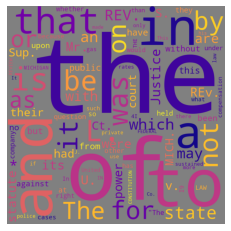

In [6]:
generate_word_cloud(df['unigramCount'].iloc[0])

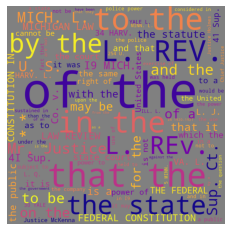

In [7]:
generate_word_cloud(df['bigramCount'].iloc[0])

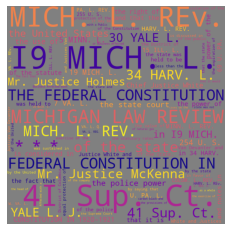

In [8]:
generate_word_cloud(df['trigramCount'].iloc[0])

As we no doubt all know, it's good to do quite a lot of data cleaning before we jump into any analysis; if we had yet to do any cleaning before generating the clouds, the figures above show us a number of "stopwords" ("the", "in", etc.) that we are probably going to want to remove. (We can note also that the WordCloud [documentation for the WordCloud class](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html?highlight=generate%20from%20frequencies) explicitly states that if one uses the `generate_from_frequencies` function, the standard stopwords are "[i]gnored if using `generate_from_frequencies`.") Rather than relying on a pre-existing function to remove these stopwords from the text we're interested in, let's practice a little bit and write our own function. We'll initialize a short list that contains some of the standard English stopwords and then remove them from the list with our function. First we set the `STOPWORDS` list from the WordCloud library and then create our test list. And, let's show a couple of different ways to do this—one using a good ol' [Python list comprehension](https://realpython.com/list-comprehension-python/) and the other with a custom function we create:

In [9]:
def sort_a_dictionary_by_values(dictionary):
    sorted_dict = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
    return(sorted_dict)

In [10]:
stop_words = set(STOPWORDS)
# We can see all the stopwords if we simply `print(stop_words)`

# Let's initialize our test list:
test_list = ['the', 'and', 'has', 'hello', 'howdy', 'doody!']

# Option 1: using a simply list comprehension to remove all the items in the list that are not in the stopwords list:
cleaned_list = [i for i in test_list if i not in stop_words]

# Option 2: let's write our own function:
def remove_stopwords_from_a_list(input_list):
    cleaned_list = [i for i in input_list if i not in stop_words]
    return(cleaned_list)

Now let's test these two avenues to make sure they both produce the same result (and the result we want too!):

In [11]:
option_1_cleaned_list = [i for i in test_list if i not in stop_words]
option_2_cleaned_list = remove_stopwords_from_a_list(test_list)
print(option_1_cleaned_list)
print(option_2_cleaned_list)

['hello', 'howdy', 'doody!']
['hello', 'howdy', 'doody!']


Yay.

Now, with the `sorted_unigram_dict` we're working with a list of tuples, how could we handle that? Well, let's write a function to help out:

In [12]:
def remove_stopwords_from_dict(dictionary):
    cleaned_dict = {k: v for k, v in dictionary.items() if k not in stop_words}
    return(cleaned_dict)

In [13]:
test_dictionary = {'the': 5673342, 'and': 2312, 'has': 2452, 'hello': 1, 'howdy': 65, 'doody!': 100}

In [14]:
remove_stopwords_from_dict(test_dictionary)

{'hello': 1, 'howdy': 65, 'doody!': 100}

Works perfectly.

In [15]:
def convert_tup_to_dict(list_of_tuples):
    result = dict(list_of_tuples)
    return(result)

In [16]:
test = [('the', 849), ('of', 499), ('to', 337), ('and', 251)]

In [17]:
result = convert_tup_to_dict(test)
result

{'the': 849, 'of': 499, 'to': 337, 'and': 251}

In [18]:
df2 = df.sort_values(by='wordCount', ascending=False).reset_index()
print(df2['wordCount'].head())
print(df2.iloc[0])

0    188662
1     87918
2     72113
3     58842
4     53578
Name: wordCount, dtype: int64
index                                                             52
creator            [JEFFREY A. ROCKWELL, BRYAN D. WATSON, JENNY A...
datePublished                                             2019-01-01
docSubType                                                       NaN
docType                                                       report
fullText           [8 CHAPTER EIGHT: PERSONNEL ISSUES – FAMILY AN...
id                           http://www.jstor.org/stable/resrep19548
identifier         [{'name': 'local_uuid', 'value': '06011b49-147...
isPartOf                                                         NaN
issueNumber                                                      NaN
language                                                       [eng]
outputFormat                    [unigram, bigram, trigram, fullText]
pageCount                                                        524
pageEnd      

In [19]:
import numpy as np
import seaborn as sns

stop_words = set(STOPWORDS)

def create_df(input):
    list_words = input.split(' ')
    set_words_full = list(set(list_words))

    set_words = [i for i in set_words_full if i not in stop_words]
    count_words = [list_words.count(i) for i in set_words]

    df = pd.DataFrame(zip(set_words, count_words), columns=['words', 'count'])
    df.sort_values('count', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [20]:
print(stop_words)

{'itself', 'me', "hadn't", 'too', 'while', "he's", 'yours', 'yourselves', 'for', 'get', 'r', "you'd", 'here', 'so', 'my', 'at', 'very', 'not', 'he', 'myself', 'on', 'ever', 'http', 'that', 'from', 'because', "weren't", 'some', 'your', 'ourselves', 'if', 'been', "they'd", "you're", 'to', 'few', "she'd", 'themselves', 'under', 'www', 'of', 'most', 'where', 'is', 'did', 'cannot', "i'll", 'am', 'out', 'how', 'had', 'more', "we've", 'were', 'however', "didn't", 'or', 'there', "we'd", 'the', 'have', 'be', 'himself', "doesn't", "let's", "mustn't", 'before', 'about', 'her', "he'll", 'them', "who's", 'these', "shouldn't", 'herself', 'him', 'we', "hasn't", 'up', 'therefore', 'only', "when's", 'why', "you've", 'shall', 'they', 'since', 'should', 'yourself', 'all', 'else', "we'll", 'when', "aren't", 'above', 'it', 'but', 'you', 'ours', "how's", "i'm", 'doing', 'otherwise', 'with', 'hers', 'com', 'and', 'below', 'theirs', "don't", 'then', "there's", "why's", "she's", 'both', 'an', 'any', 'further',

In [21]:
def get_color_dict(palette, number, start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

In [22]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
df_of_interest = df.iloc[0]
print(df_of_interest)

creator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [23]:
full_text_of_interest = df_of_interest['fullText']
full_string = " ".join(full_text_of_interest)
print(full_string[0:500])

MICHIGAN LAW REVIEW VOL. XX JANUARY, 1922 No. 3 THE SUPREME COURT'S CONSTRUCTION OF THE FEDERAL CONSTITUTION IN I920-I92I, III1 IV. PoLIcE POWER THE difficulty of classifying cases on the police power has not evaporated since the review of decisions for the preceding year. The headings there suggested are used here. Classification on the basis of the objects of the legislation appears too precarious to be attempted with any confidence. It seems safer to work along the line of the subject matters


In [24]:
import re
stop_words = set(STOPWORDS)
list_words = full_string.split(' ')
list_words = [re.sub(r'[0-9]', '', i) for i in list_words]
list_words_lower = [x.lower() for x in list_words]
list_words_alpha_only = [x for x in list_words_lower if x.isalpha() == True]
set_words_full = list(set(list_words_alpha_only))
set_words = [i for i in set_words_full if i not in stop_words]
count_words = [list_words_alpha_only.count(i) for i in set_words]

counts_df = pd.DataFrame(zip(set_words, count_words), columns=['word', 'count'])
counts_df.sort_values('count', ascending=False, inplace=True)
counts_df.reset_index(drop=True, inplace=True)
counts_df.head(10)

,word,count
0,state,68
1,may,47
2,justice,41
3,court,41
4,power,39
5,law,38
6,public,38
7,statute,35
8,without,27
9,federal,26


[Text(0, 0, 'state'),
 Text(1, 0, 'may'),
 Text(2, 0, 'justice'),
 Text(3, 0, 'court'),
 Text(4, 0, 'power'),
 Text(5, 0, 'law'),
 Text(6, 0, 'public'),
 Text(7, 0, 'statute'),
 Text(8, 0, 'without'),
 Text(9, 0, 'federal'),
 Text(10, 0, 'upon'),
 Text(11, 0, 'whether'),
 Text(12, 0, 'constitution'),
 Text(13, 0, 'held'),
 Text(14, 0, 'police'),
 Text(15, 0, 'right'),
 Text(16, 0, 'question'),
 Text(17, 0, 'company'),
 Text(18, 0, 'cases'),
 Text(19, 0, 'review'),
 Text(20, 0, 'property'),
 Text(21, 0, 'compensation'),
 Text(22, 0, 'gas'),
 Text(23, 0, 'use'),
 Text(24, 0, 'rates'),
 Text(25, 0, 'united'),
 Text(26, 0, 'see'),
 Text(27, 0, 'private'),
 Text(28, 0, 'sustained'),
 Text(29, 0, 'michigan'),
 Text(30, 0, 'regulation'),
 Text(31, 0, 'made'),
 Text(32, 0, 'states'),
 Text(33, 0, 'declared'),
 Text(34, 0, 'government'),
 Text(35, 0, 'case'),
 Text(36, 0, 'one'),
 Text(37, 0, 'railroad'),
 Text(38, 0, 'will'),
 Text(39, 0, 'supreme'),
 Text(40, 0, 'new'),
 Text(41, 0, 'subject'

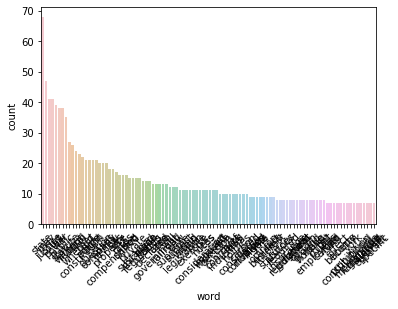

In [25]:
ax = sns.barplot(x = 'word', y = 'count', data=counts_df.iloc[0:100], alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

[[0, 20], [20, 40], [40, 60], [60, 80], [80, 100]]


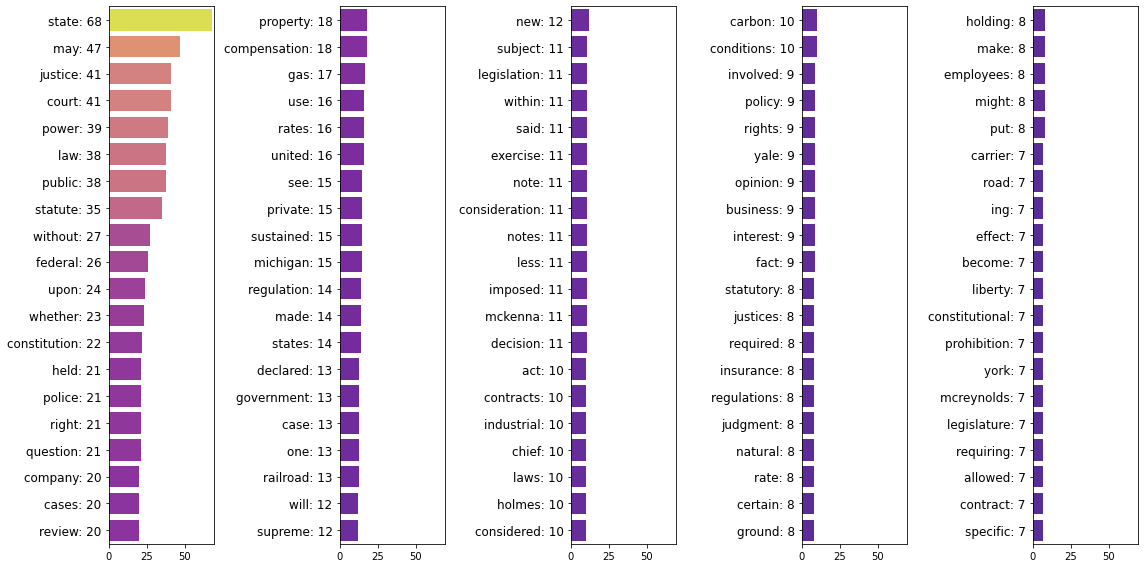

In [26]:
index_list = [[i[0], i[-1]+1] for i in np.array_split(range(100), 5)]
print(index_list)
n = counts_df['count'].max()
color_dict = get_color_dict('plasma', n, 1)

fig, axs = plt.subplots(1, 5, figsize=(16, 8), facecolor='white', squeeze=False)
for col, idx in zip(range(0, 5), index_list):
    df = counts_df[idx[0]:idx[-1]]
    #print(df)
    label = [w + ': ' + str(n) for w, n in zip(df['word'], df['count'])]
    color_l = [color_dict.get(i) for i in df['count']]
    x = list(df['count'])
    y = list(range(0, 20))

    sns.barplot(x = x, y = y, data=df, alpha=0.9, orient='h', ax = axs[0][col], palette=color_l)
    axs[0][col].set_xlim(0, n+1)
    axs[0][col].set_yticklabels(label, fontsize=12)
    #axs[0][col].spines['bottom'].set_color('white')
    #axs[0][col].spines['right'].set_color('white')
    #axs[0][col].spines['left'].set_color('white')
    #axs[0][col].spines['top'].set_color('white')

plt.tight_layout()
plt.show()

In [27]:
n = 30
pal = list(sns.color_palette(palette='tab10', n_colors=n).as_hex())

import plotly.express as px

fig = px.pie(counts_df[0:30], values='count', names='word', color_discrete_sequence=pal)

fig.update_traces(textposition='outside', textinfo='percent+label', hole=.6, hoverinfo='label+percent+name')

fig.update_layout(width=800, height=600, margin=dict(t=0, l=0, r=0, b=0))
fig.show()

In [28]:
test_string = '''
MICHIGAN LAW REVIEW VOL. XX JANUARY, 1922 No. 3 THE SUPREME COURT'S CONSTRUCTION OF THE FEDERAL CONSTITUTION IN I920-I92I, III1 IV. POLICE POWER THE difficulty of classifying cases on the police power has not evaporated since the review of decisions for the preceding year. The headings there suggested are used here. Classification on the basis of the objects of the legislation appears too precarious to be attempted with any confidence. It seems safer to work along the line of the subject matters with which the legislation deals. V. EMINENT DOMAIN and then here is some more text!
'''

contents = ['IV. POLICE POWER', 'V. EMINENT DOMAIN']

processed_text = []

part_1 = test_string.split("IV. POLICE POWER")[1]
part_2 = test_string.split('V. EMINENT DOMAIN')[1]
print(part_1)
print(part_2)

 THE difficulty of classifying cases on the police power has not evaporated since the review of decisions for the preceding year. The headings there suggested are used here. Classification on the basis of the objects of the legislation appears too precarious to be attempted with any confidence. It seems safer to work along the line of the subject matters with which the legislation deals. V. EMINENT DOMAIN and then here is some more text!

 and then here is some more text!



In [29]:
contents = ['IV. POLICE POWER', 'V. EMINENT DOMAIN']

with open('fullText.txt', encoding='utf-8') as f:
    text = f.read()

test_string = ''' 
        Here is some filler material. IV. POLICE POWER Here is some text that goes under this particular section. V. EMINENT DOMAIN And then here is some text under a different section and heading.
'''

start = text.find(contents[0])
end = text.find(contents[1])
print(start)
print(end)

section_1 = text[start:end]
#print(section_1)

section_2 = text[end:len(text)]
print(section_2)


128
62516
V. EMINENT DOMAIN Condemnation proceedings by the United States government brought four cases to the Supreme Court. United States v. Rogers43 and United States v. Highsmith,44 in applying the established prin- ciple that just compensation must be compensation as of the time when private owners are deprived of their property, allowed inter- est from the time when lands were flooded by the works constructed by the government. The flooding involved in Bothwell v. United States45 caused the destruction of hay on the lands taken and the enforced sale of cattle at prices below their true value. No com- pensation for these items was allowed in the condemnation pro- ceedings. The owners, instead of appealing, brought an action against the government in the court of claims, which gave judgment for the value of the hay but not for the loss on the cattle. The government did not appeal, and so the Supreme Court refused to consider whether compensation for the hay was rightly given. As to

In [30]:
def get_df(input_text):
    list_words = input_text.split(' ')
    set_words_full = list(set(list_words))
    
    #remove stop words
    set_words = [i for i in set_words_full if i not in stop_words]
    
    #count each word
    count_words = [list_words.count(i) for i in set_words]
    
    #create DataFrame
    df = pd.DataFrame(zip(set_words, count_words), columns=['words','count'])
    df.sort_values('count', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [31]:
combined_sections = section_1.split(' ') + section_2.split(' ')

#print(combined_sections)
df_section_words = [list(get_df(i)['words'][0:50]) for i in combined_sections]
df_section_counts = [list(get_df(i)['count'][0:50]) for i in combined_sections]
df_section_contents = [[x.lower()] * len(y) for x, y in zip(contents, df_section_words)]

df_cont = pd.DataFrame(zip(sum(df_section_contents, []), sum(df_section_words, []), sum(df_section_counts, [])), columns=['contents', 'words', 'counts'])
df_cont.head(20)

,contents,words,counts
0,iv. police power,IV.,1
1,v. eminent domain,POLICE,1


In [32]:
fig = px.sunburst(df, path=['word'], values='count')
fig.show()

In [33]:
import numpy as np
fig = px.treemap(counts_df[0:50], path=[px.Constant("word counts"), 'word'],
    values = 'count',
    color='count',
    color_continuous_scale='plasma',
    color_continuous_midpoint=np.average(counts_df['count']))

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()


In [34]:
import circlify

circles = circlify.circlify(counts_df['count'][0:30].tolist(),
    show_enclosure=False,
    target_enclosure=circlify.Circle(x=0, y=0))

n = counts_df['count'][0:30].max()
color_dict = get_color_dict('plasma', n, 1)

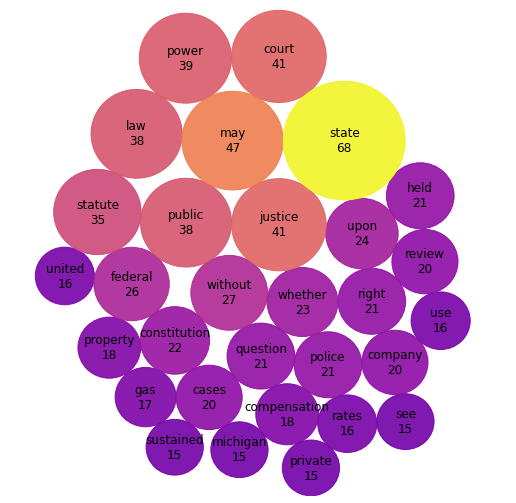

In [35]:
fig, ax = plt.subplots(figsize=(9, 9), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+ circle.r, abs(circle.y)+circle.r) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

labels = list(counts_df['word'][0:30])
counts = list(counts_df['count'][0:30])
labels.reverse()
counts.reverse()

for circle, label, count in zip(circles, labels, counts):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color=color_dict.get(count)))
    plt.annotate(label + '\n' + str(count), (x,y), size=12, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

## Top2Vec Topic Modeling:

Let's see what we can see if we do a little topic modeling with our dataset using the really wonderful little library [Top2Vec](https://github.com/ddangelov/Top2Vec).

In [40]:
from top2vec import Top2Vec

In [49]:
df = pd.read_json(gzip.open('law_full.jsonl.gz'), lines=True)

df['liststring'] = df['fullText'].transform(lambda x: " ".join(map(str, x)))
docs = df['liststring'].tolist()

In [50]:
top2vec_model = Top2Vec(docs)

2022-08-22 13:25:19,892 - top2vec - INFO - Pre-processing documents for training
2022-08-22 13:25:25,712 - top2vec - INFO - Creating joint document/word embedding
2022-08-22 13:28:54,436 - top2vec - INFO - Creating lower dimension embedding of documents
2022-08-22 13:29:02,224 - top2vec - INFO - Finding dense areas of documents
2022-08-22 13:29:02,300 - top2vec - INFO - Finding topics


In [51]:
vectors = top2vec_model._get_document_vectors()

In [52]:
top2vec_model.get_num_topics()

2

In [53]:
top2vec_model.topic_words

array([['platforms', 'disinformation', 'european', 'democratic',
        'digital', 'online', 'content', 'technology', 'cyber',
        'copyright', 'users', 'social', 'fake', 'internet', 'media',
        'technologies', 'global', 'expression', 'facebook',
        'technological', 'technical', 'transparency', 'governance', 'eu',
        'moderation', 'freedoms', 'intellectual', 'advertising',
        'deepfakes', 'influence', 'companies', 'communia', 'society',
        'russian', 'approach', 'user', 'platform', 'china', 'domain',
        'marketing', 'networks', 'access', 'deepfake', 'actors',
        'information', 'privacy', 'scientists', 'regulatory',
        'scientific', 'protection'],
       ['holmes', 'utterances', 'utterance', 'upon', 'sedition', 'mr',
        'words', 'constitution', 'chafee', 'brandeis', 'abrams', 'shall',
        'espionage', 'tendency', 'war', 'constitutional', 'declared',
        'schenck', 'opinion', 'forbidden', 'ground', 'sup', 'men',
        'matter', 

In [57]:
documents, document_scores, document_ids = top2vec_model.search_documents_by_topic(topic_num=0, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc[0:250])
    print("-----------")

Document: 73, Score: 0.42413386702537537
-----------
Susan Etlinger What’s So Difficult about Social Media Platform Governance? 20 D uring the past few years, the global build community and bring the world closer conversation about responsible together.” Twitter’s is “to give everyone technology has in
-----------
Document: 90, Score: 0.3783544898033142
-----------
I. Introducing the Digital Public Domain THE DIGITAL PUBLIC DOMAIN21March.indd 1 3/26/12 3:22 PM THE DIGITAL PUBLIC DOMAIN21March.indd 2 3/26/12 3:22 PM 1. Communia and the European Public Domain Project: A Politics of the Public Domain Giancarlo Fro
-----------
Document: 57, Score: 0.37195444107055664
-----------
CHAPTER SEVEN: CRITICAL INFRASTRUCTURE AND THE INTERNET OF THINGS CHAPTER SEVEN: CRITICAL INFRASTRUCTURE AND THE INTERNET OF THINGS Tobby Simon Copyright © 2017 by Tobby Simon TObby SImON • 93 RESEARCH VOLUmE FIVE: CybER SECURITy IN A VOLATILE WORLD 
-----------
Document: 23, Score: 0.3707291781902313
-----------
5

In [59]:
topic_words, word_scores, topic_scores, topic_nums = top2vec_model.search_topics(keywords=["speech"], num_topics=2)
#print(topic_nums)
for topic_words, word_scores, topic_scores, topic_nums in zip(topic_words, word_scores, topic_scores, topic_nums):
    print(topic_words, word_scores, topic_scores, topic_nums)

['holmes' 'utterances' 'utterance' 'upon' 'sedition' 'mr' 'words'
 'constitution' 'chafee' 'brandeis' 'abrams' 'shall' 'espionage'
 'tendency' 'war' 'constitutional' 'declared' 'schenck' 'opinion'
 'forbidden' 'ground' 'sup' 'men' 'matter' 'hand' 'question' 'harv'
 'seems' 'cooley' 'thought' 'merely' 'guaranty' 'jury' 'great' 'construed'
 'danger' 'mere' 'debs' 'punish' 'statute' 'power' 'himself' 'evil'
 'discussion' 'con' 'regarded' 'trial' 'mckenna' 'punishable' 'libel'] [0.665293   0.6595784  0.64236385 0.6197966  0.59983367 0.5638151
 0.5631654  0.5610448  0.5530779  0.5518899  0.55031186 0.54262745
 0.5284358  0.5282785  0.52745974 0.52500045 0.49735105 0.49280077
 0.48584414 0.47757128 0.47740895 0.4765267  0.47419032 0.47213846
 0.47177407 0.4704059  0.46761167 0.46205822 0.4617563  0.45771173
 0.45746428 0.45706347 0.456755   0.4541319  0.44772118 0.4469652
 0.446569   0.44427592 0.44344375 0.4420344  0.44198546 0.43839
 0.43723753 0.43531084 0.43225306 0.4316225  0.43088707 0

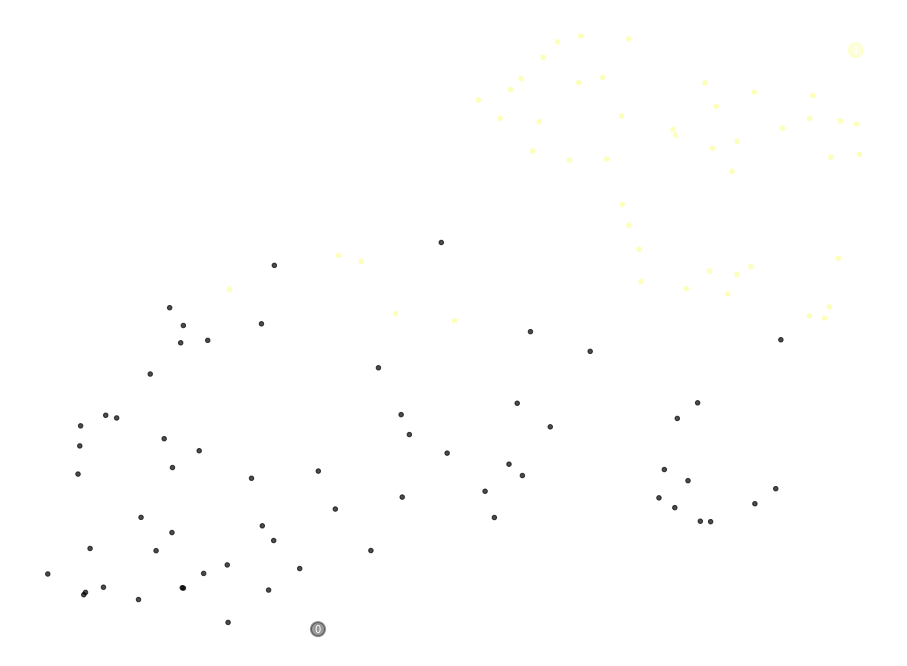

In [63]:
from top2vec import Top2Vec
import umap.plot
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def generate_documents_plot(self, background_color="white", reduced=False):
    """
    Create a documents and topics scatter plot.
    A documents and topics scatter plot will be generated and displayed.
    Documents on the same topic display in the same color. 
    On the plot, circles mean documents, and numbers mean the number of 
    topic. 
    Cautions: The plot should only be considered as approximate information
    because it is a result of dimention reduction from 5D to 2D. And it could
    be hard to distinguish for more than 20 topics. In this case, use the
    reduced option.
    Parameters
    ----------
    background_color : str (Optional, default='white')
        Background color for the plot. Suggested options are:
            * white
            * black
    reduced: bool (Optional, default False)
        Original topics are used by default. If True the
        reduced topics will be used.
    Returns
    -------
    A matplotlib plot of documents and topics
    """

    if reduced:
        self._validate_hierarchical_reduction()
        topic_vectors = self.topic_vectors_reduced
        topic_sizes, topic_nums = self.get_topic_sizes(reduced=True)
        doc_topics = self.doc_top_reduced
        doc_dist = self.doc_dist_reduced
    else:
        topic_vectors = self.topic_vectors
        topic_sizes, topic_nums = self.get_topic_sizes()
        doc_topics = self.doc_top
        doc_dist = self.doc_dist
    if len(topic_nums) <= 12:
        cmap = 'inferno'
    elif len(topic_nums) <= 20:
        cmap = 'inferno'
    else:
        cmap = 'inferno'
    # Args for UMAP. Same as current args except n_components to plot graph
    #umap_args_for_plot = self.umap_args.copy()
    umap_args_for_plot = umap_args
    # Dimension reduction
    document_vectors = self._get_document_vectors()
    topic_vectors = topic_vectors
    umap_model = umap.UMAP(**umap_args_for_plot, random_state=42).fit(document_vectors)  #  + self.topic_words
    document_vectors_2d = umap_model.embedding_  # same as umap_model.transform(self._get_document_vectors())
    topic_vectors_2d = umap_model.transform(topic_vectors)
    ## Draw a graph
    fig = plt.figure(figsize=(16, 12))
    ax = fig.subplots()
    ax.axis("off")
    fig.set_facecolor(background_color)
    # Draw document vectors
    ax.scatter(*document_vectors_2d.T, 
                s=20, c=doc_topics, cmap=cmap, alpha=0.7,  # linewidth=1, 
                )
    # Draw topic vectors
    ax.scatter(*topic_vectors_2d.T, 
                s=200, linewidth=2, c=topic_nums, cmap=cmap, alpha=0.4,
                )
    for topic_num, topic_vector_2d in zip(topic_nums, topic_vectors_2d):
        ax.annotate(topic_num, 
                    topic_vector_2d,
                    horizontalalignment='center',
                    verticalalignment='center',
                    size=10,
                    color='white') 
    plt.show()
    

top2vec_model_for_plot = top2vec_model

umap_args = {
    "n_neighbors": 15,
    "n_components": 2,
    "metric": "cosine",
    "min_dist": 0.10,
    'spread': 1
}

generate_documents_plot(top2vec_model_for_plot)

The built dataset has all of the unigrams and their counts in the `unigramCount` as a dictionary—it might be nice to sort them in descending order with the word possesssing the highest count on down. Let's write a simple function to sort the dictionary of unigrams (using the [sorted function](https://www.w3schools.com/python/ref_func_sorted.asp#:~:text=The%20sorted()%20function%20returns,string%20values%20AND%20numeric%20values)):

We could then create a new column (if we wanted) to hold the sorted dictionary using the pandas [`apply` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html):

In [36]:
df['sorted_unigram_dict'] = df['unigramCount'].apply(sort_a_dictionary_by_values)

KeyError: 'unigramCount'

Of course, we could also create a list with all the columns we wanted to apply this function to and then write a simply for loop to apply it to all the columns in our list:

In [ ]:
columns = ['unigramCount', 'bigramCount', 'trigramCount']
for column in columns:
    df[f"sorted_{column}_dict"] = df[column].apply(sort_a_dictionary_by_values)

# Then we just check to see that the function is doing what we hope it is:
df[['sorted_unigramCount_dict', 'sorted_bigramCount_dict', 'sorted_trigramCount_dict']].head()

(We might come back and utilize this a little bit more.)